In [2]:
import torch
from torch import nn
import torch.nn.functional as tf

from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, BatchEncoding, DataCollatorWithPadding

from tqdm import tqdm

import math
import os

In [3]:
pretrained_base_model_names = ["bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"]

In [ ]:
model_index = 2
pretrained_base_model_name = pretrained_base_model_names[model_index]

In [4]:
def cls_pool(features, attention_mask):
  '''
    features: (N, T, D) -> (N, D)| [(N, T, D)] -> [(N, D)]
  '''
  if isinstance(features, tuple):
    pool_result = ()
    for _, f in enumerate(features):
      pool_result += (f[:, 0, :],)
    return torch.cat(pool_result, dim=-1)
  else:
    return features[:, 0, :]

def masked_mean_pool(features, attention_mask):
  '''
    features: (N, T, D) -> (N, D) | [(N, T, D)] -> [(N, D)]
    attention_mask: (N, T) -> (N, T, 1) for broadcasting element wise multiplication
  '''
  extended_attention_mask = attention_mask[:, :, None].to(dtype=torch.float32)
  if isinstance(features, tuple):
    pool_result = ()
    for _, f in enumerate(features):
      masked_features = torch.mul(f, extended_attention_mask)
      pool_result += (torch.sum(masked_features, dim=1)/torch.sum(extended_attention_mask, dim=1),)

    return torch.cat(pool_result, dim=-1)
  else:
    masked_features = torch.mul(features, extended_attention_mask)
    return torch.sum(masked_features, dim=1)/torch.sum(extended_attention_mask, dim=1)

In [5]:
ACT_MAPPER = {
    "gelu": tf.gelu,
    "tanh": tf.tanh,
    "hardtanh": tf.hardtanh,
    "linear": tf.linear,
    None: tf.linear
}
POOL_MAPPER = {
    "cls": cls_pool,
    "mean": masked_mean_pool
}

In [6]:
class Classifier(nn.Module):
  def __init__(self, num_classes, input_size, intermediate_size, act_fn):
    super(Classifier, self).__init__()

    self.fc = nn.Linear(input_size, intermediate_size)
    self.output_fc = nn.Linear(intermediate_size, num_classes)
    self.act_fn = act_fn

    self.__init_weights()

  def __init_weights(self):
    nn.init.kaiming_normal_(self.fc.weight)
    nn.init.xavier_normal_(self.output_fc.weight)

  def forward(self, x):
    x = self.act_fn(self.fc(x))
    logits = self.output_fc(x)
    return logits

In [7]:
class BoolQuestionAnswering(nn.Module):
  def __init__(self, base_model_name, num_classes, classifier_activation="gelu", pool_method="cls", output_hidden_layers=1, intermediate_size_proportion=4):
    super(BoolQuestionAnswering, self).__init__()

    self.num_classes = num_classes

    if pool_method is None or output_hidden_layers < 1:
      raise ValueError()

    self.pool_method = POOL_MAPPER[pool_method]
    self.output_hidden_layers = output_hidden_layers

    self.feature_extractor = AutoModel.from_pretrained(base_model_name, output_hidden_states=output_hidden_layers > 1)

    self.hidden_size = 768
    self.cls_input_size = output_hidden_layers*self.hidden_size
    self.intermediate_size = self.hidden_size*intermediate_size_proportion

    self.classifier = Classifier(num_classes, self.cls_input_size, self.intermediate_size, ACT_MAPPER[classifier_activation])

    self.loss_fn = tf.cross_entropy

  def forward(self, input_ids, attention_mask):
    outputs = self.feature_extractor(input_ids, attention_mask)
    if self.output_hidden_layers > 1:
      features = outputs.hidden_states[-self.output_hidden_layers:]
    else:
      features = outputs.last_hidden_state

    pooled_features = self.pool_method(features, attention_mask)

    logits = self.classifier(pooled_features)
    return logits

  def save(self, model_name: str, weights_only: bool = True):
    save_path = os.path.join("save", model_name)
    # Check whether the specified path exists or not
    is_exist = os.path.exists(save_path)
    if not is_exist:
      # Create a new directory because it does not exist
      os.makedirs(save_path)
    else:
      print(f"There is already a model saved with the name {model_name}, which will be overwritten by new version!")
    if weights_only:
      weights_file = "qa-weights.pt"
      torch.save(self.state_dict(), os.path.join(save_path, weights_file))
    else:
      model_file = "qa-model.pt"
      torch.save(self, os.path.join(save_path, model_file))




# ViQuAD data

In [8]:
def load_tokenizer(tokenizer_name):
  return AutoTokenizer.from_pretrained(tokenizer_name)

In [9]:
tokenizer = load_tokenizer(pretrained_base_model_name)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
def read_data(input_file):
    with open(input_file, "r", encoding="utf-8") as f:
        columns = f.readline().strip().split('\t')
        data = {col_name: [] for col_name in columns}
        num_cols = len(columns)
        n = 0
        for line in f:
            n += 1
            line = line.replace('\n', "")
            values = line.split("\t")
            if len(values) != num_cols:
                raise ValueError(f"Expected {num_cols} columns, found {len(values)} columns!")
            for i in range(len(values)):
                data[columns[i]].append(values[i])

    # ['id', 'title', 'context', 'question', 'has_answer', 'start_index', 'answer']

    del data["title"]
    data["size"] = n
    return data

In [27]:
def convert_data_to_samples(data, tokenizer, max_chunk_size=512, chunk_overlap_size=256):
  def find_context_start_index(sequence_ids):
    for i in range(len(sequence_ids)):
      if sequence_ids[i] == 2:
        return i + 2
    return 0

  def find_context_end_index(sequence_ids):
    for i in range(len(sequence_ids)-1, 0, -1):
      if sequence_ids[i] == 2:
        return i - 1
    return len(sequence_ids) - 2

  questions = data["question"]
  contexts = data["context"]
  has_answer_list = data["has_answer"]
  start_index_list = data["start_index"]
  answers = data["answer"]

  all_samples = []

  for i in tqdm(range(data["size"])):
    question = questions[i]
    context = contexts[i]
    has_answer = has_answer_list[i]
    start_index = int(start_index_list[i])
    answer = answers[i]

    answer_len = len(answer)

    end_index = start_index + answer_len

    encoding = tokenizer(question,
                         context,
                         truncation="only_second",
                         max_length=max_chunk_size,
                         stride=chunk_overlap_size,
                         return_overflowing_tokens=True,
                         return_offsets_mapping=True,
                         padding="max_length")

    input_ids = encoding.input_ids
    offset_mappings = encoding.offset_mapping
    attention_masks = encoding.attention_mask

    context_start_index = find_context_start_index(input_ids[0])
    for ids, offset_mapping, attention_mask in zip(input_ids, offset_mappings, attention_masks):

      context_start_index = find_context_start_index(ids)
      context_end_index = find_context_end_index(ids)

      if offset_mapping[context_start_index][0] <= start_index and offset_mapping[context_end_index][1] >= end_index:
        label = 1
      else:
        label = 0

      samples = BatchEncoding({
          "input_ids": ids,
          "attention_mask": attention_mask,
          "label": label
      })

      all_samples.append(samples)

  return all_samples


In [28]:
class SquadDataset(Dataset):
  def __init__(self, encodings):
        self.encodings = encodings
        self.num_samples = len(encodings)

  def __len__(self):
      return self.num_samples

  def __getitem__(self, idx):
      encoding = self.encodings[idx]

      return encoding

def create_dataset(input_file, tokenizer):
  data = read_data(input_file)
  train_samples = convert_data_to_samples(data, tokenizer)
  ds = SquadDataset(train_samples)
  return ds

In [29]:
!gdown --id 1JwUYWOaYU71vesQHLsmRxxeSQKMLV14F
!gdown --id 1MX2nS5uTns7aUfAn71kJWt-2pmBcKVQh

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JwUYWOaYU71vesQHLsmRxxeSQKMLV14F
To: /content/train.tsv
100% 35.8M/35.8M [00:00<00:00, 58.6MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MX2nS5uTns7aUfAn71kJWt-2pmBcKVQh
To: /content/dev.tsv
100% 10.8M/10.8M [00:00<00:00, 52.9MB/s]


In [30]:
train_ds = create_dataset("/content/train.tsv", tokenizer)
val_ds = create_dataset("/content/dev.tsv", tokenizer)

100%|██████████| 8537/8537 [00:09<00:00, 854.53it/s]


In [31]:
train_dataloader = DataLoader(train_ds, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_ds, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True, batch_size=32)

In [32]:
print(len(train_dataloader))
print(len(val_dataloader))

3600
270


# Optimizer

In [33]:
from sklearn.metrics import f1_score, accuracy_score
from torch.optim.lr_scheduler import LRScheduler

In [34]:
class WarmupLinearLR(LRScheduler):
    def __init__(self,
                 optimizer,
                 warmup_steps,
                 total_steps,
                 min_proportion=0.0,
                 last_epoch=-1,
                 verbose=False):

        self.warmup_steps = warmup_steps
        self.max_steps = (total_steps - min_proportion * warmup_steps) / (1.0 - min_proportion)
        super(WarmupLinearLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if self.last_epoch == 0:
            return [group['lr'] * 0.1 / self.warmup_steps for group in self.optimizer.param_groups]

        if self.last_epoch > self.max_steps:
            return [group['lr'] for group in self.optimizer.param_groups]

        if self.last_epoch < self.warmup_steps:
            return [group['initial_lr'] * self.last_epoch / self.warmup_steps for group in self.optimizer.param_groups]
        else:
            return [group['initial_lr'] * (self.max_steps - self.last_epoch) / (self.max_steps - self.warmup_steps) for
                    group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [base_lr * self.last_epoch / self.warmup_steps for base_lr in self.base_lrs]
        else:
            return [base_lr * (self.max_steps - self.last_epoch) / (self.max_steps - self.warmup_steps) for base_lr
                    in self.base_lrs]


In [35]:
EPOCHS = 15
gradient_accumulation_steps = 4
batchs_per_epoch = len(train_dataloader)
total_steps = EPOCHS * math.ceil(len(train_dataloader) / gradient_accumulation_steps)
warmup_steps = int(total_steps*0.1)

# Training

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
model = BoolQuestionAnswering(pretrained_base_model_name, num_classes=2, pool_method="mean").to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [38]:
no_decay = ['bias', 'layer_norm.weight']
optimizer_grouped_parameters = [
  {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
    'weight_decay': 0.0001},
  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
    'weight_decay': 0.0}
]

In [39]:
sum(p.numel() for p in model.parameters())

280412162

In [40]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5, weight_decay=0.0)
scheduler = WarmupLinearLR(optimizer, warmup_steps, total_steps, min_proportion=0.0)

In [41]:
max_grad_norm = 1.0
eval_steps = 100
save_checkpoint = True

In [42]:
!mkdir logs
!mkdir save

In [43]:
def evaluate(model, val_dataloader, val_steps):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        y_trues = []
        y_preds = []

        for batch in val_dataloader:
            batch = batch.to(device)

            logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

            expanded_targets = batch["labels"][:, None]

            probabilities_targets = torch.cat((1.0 - expanded_targets, expanded_targets), dim=1)

            loss = tf.cross_entropy(logits, probabilities_targets)

            labels = (batch["labels"] > 0.5).int()

            predicts = torch.argmax(logits, dim=1)
            y_preds.extend(predicts.cpu().numpy().tolist())
            y_trues.extend(labels.cpu().numpy().tolist())

            total_loss += loss.item()

        f1 = f1_score(y_trues, y_preds, average="weighted")
        accuracy = accuracy_score(y_trues, y_preds)

        validation_result = {
            "loss": round(total_loss / val_steps, 4),
            "accuracy": round(accuracy, 4),
            "f1": round(f1, 4)
        }

    return validation_result


In [45]:
log_writer = open("logs/train-qa.log", "w")
log_writer.write("               ***** Start training *****\n")
log_writer.write("============================================================\n")
log_writer.write(f"Num samples: {len(train_ds)}\n")
log_writer.write(f"Num epochs: {EPOCHS}\n")
log_writer.write(f"Gradient accumulation steps = {gradient_accumulation_steps}\n")
log_writer.write("============================================================\n")

monitor_f1 = float('-inf')

step = 0
global_steps = 0

optimizer.zero_grad()

history_f1 = []

for epoch in range(EPOCHS):

    total_loss = 0.0
    y_trues = []
    y_preds = []

    log_writer.write("------------------------------------------------------------\n")
    log_writer.write(f"Epoch {epoch + 1:>3d}/{EPOCHS}:\n")

    print(f"\033[92mEpoch\033[00m {epoch + 1:>3d}/{EPOCHS}:")

    for batch_idx, batch in enumerate(train_dataloader):
        # print(f"\r- \033[96mStep\033[00m {step + 1:>5d}/{steps_per_epoch}:", end="")

        model.train()

        batch = batch.to(device)

        logits = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

        expanded_targets = batch["labels"][:, None]

        probabilities_targets = torch.cat((1.0 - expanded_targets, expanded_targets), dim=1)

        loss = model.loss_fn(logits, probabilities_targets)

        print(f"\r- \033[96mBatch\033[00m {batch_idx + 1:>4d}/{batchs_per_epoch} "
              f"(\033[96mstep\033[00m {step + 1}) "
              f"(\033[96mglobal step\033[00m {global_steps + 1}): "
              f"batch loss: {round(loss.item(), 4)}", end="")

        labels = (batch["labels"] > 0.5).int()

        predicts = torch.argmax(logits, dim=1)
        y_preds.extend(predicts.cpu().numpy().tolist())
        y_trues.extend(labels.cpu().numpy().tolist())

        total_loss += loss.item()
        loss /= gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()  # Update gradients
            scheduler.step()  # Update learning rate schedule

            global_steps += 1

            optimizer.zero_grad()

            if global_steps % eval_steps == 0:
                print()
                logging_line = (f"\r- \033[96mBatch\033[00m {batch_idx + 1:>4d}/{batchs_per_epoch} "
                                f"(\033[96mstep\033[00m {step + 1}) "
                                f"(\033[96mglobal step\033[00m {global_steps + 1}): "
                                f"lr: {scheduler.get_last_lr()}\n")

                log_writer.write(logging_line)

                f1 = f1_score(y_trues, y_preds, average="weighted")
                accuracy = accuracy_score(y_trues, y_preds)

                train_acc_loss = round(total_loss / (batch_idx + 1), 4)
                train_acc_f1 = round(f1, 4)
                train_acc_accuracy = round(accuracy, 4)

                train_result_line = (f"\033[95m{'loss':8s}\033[00m: {train_acc_loss:<10.4f} "
                                     f"\033[95m{'accuracy':12s}\033[00m: {train_acc_accuracy:<10.4f} "
                                     f"\033[95m{'f1':6s}\033[00m: {train_acc_f1:<10.4f}")

                print(f"    {train_result_line}")
                log_writer.write(f"    {train_result_line}\n")

                validation_output = evaluate(model, val_dataloader, len(val_dataloader))

                val_result_line = (f"\033[95mval_loss\033[00m: {validation_output['loss']:<10.4f} "
                                   f"\033[95mval_accuracy\033[00m: {validation_output['accuracy']:<10.4f} "
                                   f"\033[95mval_f1\033[00m: {validation_output['f1']:<10.4f}")
                history_f1.append((global_steps, validation_output['f1']))

                print(f"    {val_result_line}")
                log_writer.write(f"    {val_result_line}\n")
                if save_checkpoint:
                    if validation_output['f1'] > monitor_f1:
                        model.save("xlm-roberta-base-qa")
                        log_writer.write(
                          f"    # val_f1 improve from {monitor_f1} to {validation_output['f1']}. "
                          "Saving model with name \"xlm-roberta-base-qa\"")
                        monitor_f1 = validation_output["f1"]

                log_writer.write("\n")

        step += 1

log_writer.write("                ***** End training *****\n")
log_writer.close()

In [48]:
from matplotlib import pyplot as plt

In [135]:
torch.save(history_f1, "history_f1.pt")

In [136]:
history_f1 = torch.load("history_f1.pt")

In [138]:
f1, step = [], []
for a, b in history_f1:
  step.append(a)
  f1.append(b)

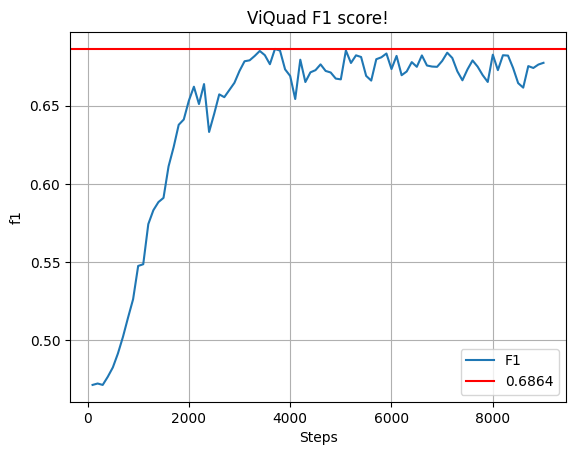

In [141]:
plt.plot(step, f1, label="F1")
plt.axhline(y=max(f1), color = 'r', linestyle = '-', label=str(max(f1)))

plt.title("ViQuad F1 score!")
plt.legend()

plt.xlabel("Steps")
plt.ylabel("f1")

plt.grid()
plt.show()

In [121]:
!zip state_dict.zip /content/save/xlm-roberta-base-qa/qa-weights.pt

  adding: content/save/xlm-roberta-base-qa/qa-weights.pt (deflated 30%)


In [120]:
!du -sh /content/save/

1.1G	/content/save/


In [137]:
!cp -r /content/state_dict.zip /content/drive/MyDrive/Solves/

In [142]:
!cp -r /content/history_f1.pt /content/drive/MyDrive/Solves/

# Hard negative

In [ ]:
# hard_negatives = []

In [ ]:
# model.eval()
# with torch.no_grad():
#   for sample in val_dataloader:
#     logits = model(sample)
#     list_abs = abs(logits[:, 0] - logits[:, 1])
#     if any(list_abs < 0.2):
#       print(sample.tokens())
#       hard_negatives.append(sample)

In [ ]:
# 0.4 - 0.6

In [ ]:
6000/28000

# Reserved

In [ ]:
# def convert_data_to_samples(data, tokenizer, max_chunk_size=512, chunk_overlap_size=256):
#   def find_context_start_index(sequence_ids):
#     for i in range(len(sequence_ids)):
#       if sequence_ids[i] == 2:
#         return i + 2
#     return 0

#   def find_context_end_index(sequence_ids):
#     for i in range(len(sequence_ids)-1, 0, -1):
#       if sequence_ids[i] == 2:
#         return i - 1
#     return len(sequence_ids)

#   questions = data["question"]
#   contexts = data["context"]
#   has_answer_list = data["has_answer"]
#   start_index_list = data["start_index"]
#   answers = data["answer"]

#   all_samples = []

#   for i in tqdm(range(data["size"])):
#     question = questions[i]
#     context = contexts[i]
#     has_answer = has_answer_list[i]
#     start_index = int(start_index_list[i])
#     answer = answers[i]

#     answer_len = len(answer)

#     end_index = start_index + answer_len

#     encoding = tokenizer(question,
#                          context,
#                          truncation="only_second",
#                          max_length=max_chunk_size,
#                          stride=chunk_overlap_size,
#                          return_overflowing_tokens=True,
#                          return_offsets_mapping=True,
#                          padding="max_length")

#     input_ids = encoding.input_ids
#     offset_mappings = encoding.offset_mapping
#     attention_masks = encoding.attention_mask

#     context_start_index = find_context_start_index(input_ids[0])
#     for ids, offset_mapping, attention_mask in zip(input_ids, offset_mappings, attention_masks):

#       context_start_index = find_context_start_index(ids)
#       context_end_index = find_context_end_index(ids)

#       if offset_mapping[context_start_index][0] <= start_index and offset_mapping[context_end_index][1] >= end_index:
#         label = 1
#       elif offset_mapping[context_start_index][0] <= start_index and offset_mapping[context_end_index][1] >= start_index:
#         num_chars = offset_mapping[context_end_index][1] - start_index
#         if num_chars == 0:
#           label = 0
#         else:
#           label = 0.5*(1.0 + num_chars/answer_len)
#       elif offset_mapping[context_start_index][0] <= end_index and offset_mapping[context_end_index][1] >= end_index:
#         num_chars = end_index - offset_mapping[context_start_index][0]
#         if num_chars == 0:
#           label = 0
#         else:
#           label = 0.5*(1.0 + num_chars/answer_len)
#       else:
#         label = 0

#       samples = BatchEncoding({
#           "input_ids": ids,
#           "attention_mask": attention_mask,
#           "label": label
#       })

#       all_samples.append(samples)

#   return all_samples
